In [1]:
import numpy as np
import torch
import random
import pandas as pd
import pickle

from src.wrapper import RestrictionWrapper
from examples.agents.td3 import TD3
from examples.envs.navigation import NavigationEnvironment
from examples.restrictors.navigation_restrictor import NavigationRestrictor
from examples.utils import ReplayBuffer
from src.restrictions import IntervalUnionRestriction

In [2]:
# Tested with seeds 46, 47, 48, 49
seed = 48
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [23]:
path = None

if path:
    with open(path, 'rb') as f:
        all_results_df = pickle.load(f)
else:
    all_results_df = pd.DataFrame(columns=['seed', 'return', 'solved', 'steps', 'training_steps'])

In [4]:
env_config = {
    'HEIGHT': 15.0,
    'WIDTH': 15.0,
    'STEPS_PER_EPISODE': 60,
    'ACTION_RANGE': 220,
    'DT': 1.0,
    'TIMESTEP_PENALTY_COEFFICIENT': 0.05,
    'REWARD_COLLISION': -1.0,
    'REWARD_GOAL': 5.0,
    'REWARD_COEFFICIENT': 10.0,
    'AGENT_RADIUS': 0.5,
    'AGENT_PERSPECTIVE': 90,
    'AGENT_STEP_SIZE': 1.0,
    'AGENT_X': 1.5,
    'AGENT_Y': 1.5,
    'GOAL_RADIUS': 1.0,
    'GOAL_X': 12.0,
    'GOAL_y': 12.0
}
environment = NavigationEnvironment(env_config)

In [5]:
restrictor = NavigationRestrictor(obstacle_count=7,
                                  obstacle_position_covariance=[[4.0, 0.0], [0.0, 4.0]],
                                  obstacle_mean_size=1.0,
                                  obstacle_variance_size=0.2,
                                  obstacle_size_range=0.5,
                                  start_seed=50,
                                  safety_angle=8,
                                  min_angle=-110.0,
                                  max_angle=110.0)

In [6]:
def do_nothing_on_invalid(env, action, restriction):
    env._cumulative_rewards = {'agent_0': 0.0}
    env.rewards = {'agent_0': 0.0}
    env.trajectory.append([float(env.agent.x),
                           float(env.agent.y)])
    env.current_step += 1
    if env.current_step >= env.STEPS_PER_EPISODE:
        env.truncations = {'agent_0': True}

def projection(env, action, restriction: IntervalUnionRestriction):
    env.step(np.array([restriction.nearest_element(action[0])], dtype=np.float32))

restriction_violation_fns = projection
restricted_environment = RestrictionWrapper(environment, restrictor,
                                            restriction_violation_fns=restriction_violation_fns)

In [7]:
td3_config = {
    'state_dim': 6,
    'action_dim': 1,
    'max_action': 110.0,
    'discount': 0.99,
    'tau': 0.005,
    'policy_noise': 0.2,
    'noise_clip:': 0.5,
    'policy_freq': 2,
    'exploration_noise': 0.2,
    'exploration_noise_final': 0.02,
    'exploration_timesteps': 30000,
    'batch_size': 256,
    'train_after_timesteps': 2000,
    'learning_rate_actor': 1e-5,
    'learning_rate_critic': 1e-5
}

total_timesteps = 50000
evaluation_frequency = 500
sample_from_restricted_space = False
td3 = TD3(**td3_config)
replay_buffer = ReplayBuffer(state_dim=td3_config['state_dim'], action_dim=td3_config['action_dim'])

In [8]:
evaluation_envs = 20

def evaluate(eval_policy: TD3):
    eval_restrictor = NavigationRestrictor(obstacle_count=7,
                                                       obstacle_position_covariance=[[4.0, 0.0], [0.0, 4.0]],
                                                       obstacle_mean_size=1.0,
                                                       obstacle_variance_size=0.2,
                                                       obstacle_size_range=0.5,
                                                       start_seed=1,
                                                       safety_angle=8,
                                                       min_angle=-110.0,
                                                       max_angle=110.0)
    eval_env = RestrictionWrapper(NavigationEnvironment(env_config),
                                  eval_restrictor,
                                  restriction_violation_fns=restriction_violation_fns)

    solved = []
    all_rewards = []
    all_steps = []
    for it in range(evaluation_envs):
        eval_reward = 0.0
        eval_steps = 0
        eval_env.reset()
        for eval_agent in eval_env.agent_iter():
            obs, rew, term, trunc, inf = eval_env.last()
            if eval_agent == 'agent_0':
                eval_steps += 1
                eval_reward += rew
                eval_action = eval_policy.select_action(obs['observation'])
            else:
                eval_action = eval_restrictor.act(obs)

            if term or trunc:
                eval_action = None
                if eval_agent == 'agent_0':
                    solved.append(term)

            eval_env.step(eval_action)

        all_rewards.append(eval_reward)
        all_steps.append(eval_steps)

    return sum(all_rewards) / len(all_rewards), sum(solved) / len(solved), sum(all_steps) / len(all_steps)

In [9]:
episode_num = 0
training_timesteps = 0

ev_reward_all = []
ev_solved_all = []
ev_steps_all = []

exploration_annealing_rate = (td3_config['exploration_noise'] - td3_config['exploration_noise_final']
                              ) / td3_config['exploration_timesteps']
noise_factor = td3_config['exploration_noise']
while training_timesteps < total_timesteps:
    restricted_environment.reset()
    episode_reward = 0
    episode_timesteps = 0
    episode_num += 1
    observation = None
    action = None
    last_td3_action = None

    for agent in restricted_environment.agent_iter():
        next_observation, reward, termination, truncation, info = restricted_environment.last()

        # Turn of the agent
        if agent == 'agent_0':
            episode_reward += reward
            episode_timesteps += 1

            flattened_next_observation = next_observation['observation']

            if episode_timesteps > 1:
                replay_buffer.add(observation,
                                  last_td3_action,
                                  flattened_next_observation,
                                  reward,
                                  termination or truncation)
            observation = flattened_next_observation

            training_timesteps += 1
            if training_timesteps < td3_config['train_after_timesteps']:
                if sample_from_restricted_space:
                    action = next_observation['restriction'].sample()
                else:
                    action = np.random.uniform(-110.0, 110.0, (1,))
            else:
                det_action = td3.select_action(observation)
                noise = np.random.normal(0, td3_config['max_action'] * noise_factor,
                                         size=td3_config['action_dim'])
                action = (det_action + noise).clip(-td3_config['max_action'], td3_config['max_action'])

                noise_factor = max([noise_factor - exploration_annealing_rate,
                                    td3_config['exploration_noise_final']])

            if training_timesteps >= td3_config['train_after_timesteps']:
                td3.train(replay_buffer, td3_config['batch_size'])
            last_td3_action = action
        # Or restrictor
        else:
            action = restrictor.act(next_observation)

        # None action if episode is done
        if termination or truncation:
            # print(f'{action} for {next_observation["restriction"]}, {restricted_environment.env.agent.x, restricted_environment.env.agent.y}')
            action = None

        restricted_environment.step(action)

        if agent == 'agent_0' and training_timesteps % evaluation_frequency == 0:
            print('Starting evaluation ...')
            ev_reward, ev_solved, ev_steps = evaluate(td3)
            ev_reward_all.append(ev_reward)
            ev_solved_all.append(ev_solved)
            ev_steps_all.append(ev_steps)

    print(noise_factor)
    print(f'Finished episode {episode_num} with reward {episode_reward} in {episode_timesteps} steps - goal reached: {termination}')

restricted_environment.close()

Generating obstacles with seed 50
0.2
Finished episode 1 with reward 13.852774209545846 in 29 steps - goal reached: True
Generating obstacles with seed 51
0.2
Finished episode 2 with reward -79.93501663140428 in 61 steps - goal reached: False
Generating obstacles with seed 52
0.2
Finished episode 3 with reward -39.46422879829787 in 61 steps - goal reached: False
Generating obstacles with seed 53
0.2
Finished episode 4 with reward 15.9578577175556 in 61 steps - goal reached: False
Generating obstacles with seed 54
0.2
Finished episode 5 with reward -65.2911946586404 in 61 steps - goal reached: False
Generating obstacles with seed 55
0.2
Finished episode 6 with reward -20.75464870848079 in 61 steps - goal reached: False
Generating obstacles with seed 56
0.2
Finished episode 7 with reward -71.23457641763534 in 61 steps - goal reached: False
Generating obstacles with seed 57
0.2
Finished episode 8 with reward -40.64991514389196 in 61 steps - goal reached: False
Generating obstacles with se

In [22]:
td3.save('projection')

In [30]:
all = pd.concat([all_results_df_2, all_results_df]).reset_index(drop=True)

In [10]:
all_results_df = pd.concat([all_results_df, pd.DataFrame({
    'seed': [seed] * len(ev_reward_all),
    'return': ev_reward_all,
    'solved': ev_solved_all,
    'steps': ev_steps_all,
    'training_steps': range(0, total_timesteps, evaluation_frequency)
})]).reset_index(drop=True)

In [21]:
all_results_df.to_pickle('results_projection.pkl')

In [11]:
all_results_df['seed'].unique()

array([48], dtype=object)

In [13]:
len(all_results_df)

100

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

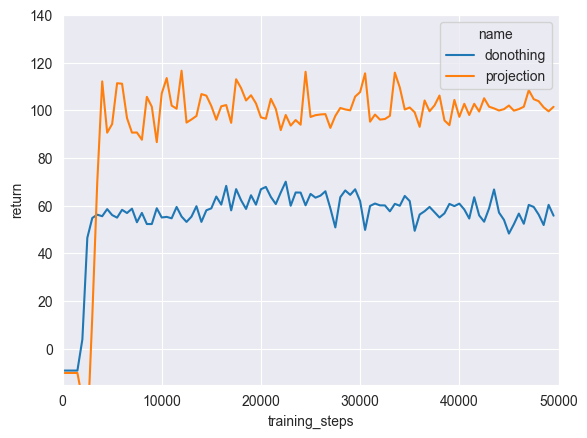

In [31]:
plt.figure()
sns.lineplot(data=all, x='training_steps', y='return', hue='name')
plt.ylim(-15.0, 140.0)
plt.xlim(0.0, 50000.0)
plt.show()

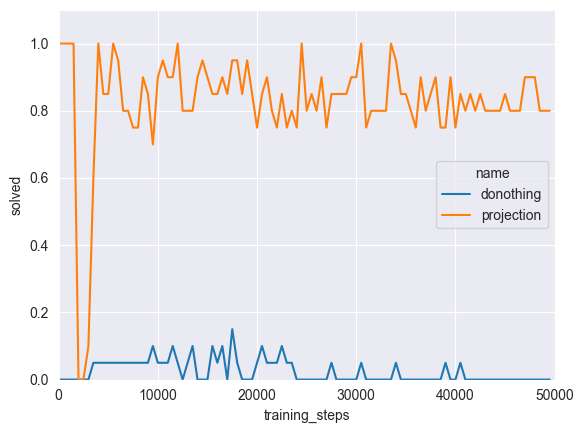

In [32]:
plt.figure()
sns.lineplot(data=all, x='training_steps', y='solved', hue='name')
plt.ylim(0.0, 1.1)
plt.xlim(0.0, 50000.0)
plt.show()

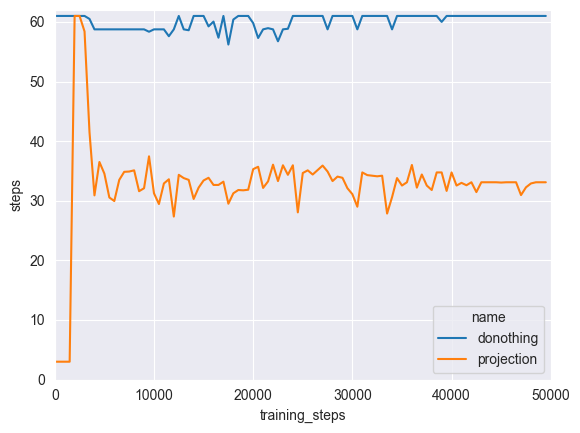

In [33]:
plt.figure()
sns.lineplot(data=all, x='training_steps', y='steps', hue='name')
plt.ylim(0.0, 62.0)
plt.xlim(0.0, 50000.0)
plt.show()

In [6]:
td3.load('replacement_1')

Generating obstacles with seed 10


/var/folders/kq/tbvpx3ts1499k34zm5wbjr9r0000gn/T/ipykernel_10172/1162512388.py:88: DeprecationWarning: blend=False will be deprecated in pygame 2.2 and will default to True
  pygame.draw.aalines(canvas, (232, 232, 232), False, np.multiply(trajectory, window_scale), 0)


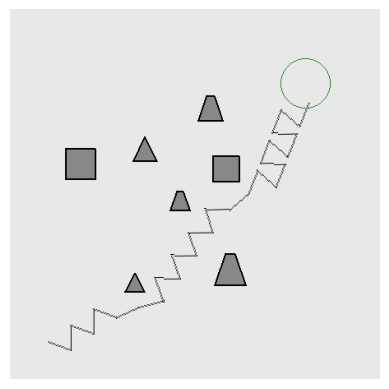

In [20]:
from gymnasium.error import DependencyNotInstalled
import matplotlib.pyplot as plt

def render(vis_policy, seed):
    """ Renders the environment

    Args:
        render_mode (str)
        draw_trajectory (bool): Whether past steps should be indicated on the map
        draw_information (bool): Whether to show information about the reward, target distance, and allowed actions
    """
    try:
        import pygame
        from pygame import gfxdraw
    except ImportError:
        raise DependencyNotInstalled('Pygame is not installed, run `pip install pygame`')

    def draw_polygon_border(polygon_coordinates):
        for index, coordinate in enumerate(polygon_coordinates):
            if index == len(polygon_coordinates) - 1:
                pygame.draw.line(canvas, (0, 0, 0), (int(coordinate[0]),
                                                     int(coordinate[1])),
                                 (int(polygon_coordinates[0][0]),
                                  int(polygon_coordinates[0][1])), 2)
            else:
                pygame.draw.line(canvas, (0, 0, 0), (int(coordinate[0]),
                                                     int(coordinate[1])),
                                 (int(polygon_coordinates[index + 1][0]),
                                  int(polygon_coordinates[index + 1][1])), 2)

    trajectory = []
    vis_restrictor = NavigationRestrictor(obstacle_count=7,
                                           obstacle_position_covariance=[[4.0, 0.0], [0.0, 4.0]],
                                           obstacle_mean_size=1.0,
                                           obstacle_variance_size=0.2,
                                           obstacle_size_range=0.5,
                                           start_seed=seed,
                                           safety_angle=8,
                                           min_angle=-110.0,
                                           max_angle=110.0)
    vis_env = RestrictionWrapper(NavigationEnvironment(env_config),
                                 vis_restrictor,
                                 restriction_violation_fns=restriction_violation_fns)
    vis_width = vis_env.env.WIDTH
    vis_height = vis_env.env.HEIGHT

    vis_env.reset()
    trajectory.append([float(vis_env.env.agent.x),
                       float(vis_env.env.agent.y)])
    for vis_agent in vis_env.agent_iter():
        obs, rew, term, trunc, inf = vis_env.last()
        if vis_agent == 'agent_0':
            vis_action = vis_policy.select_action(obs['observation'])
        else:
            vis_action = vis_restrictor.act(obs)

        if term or trunc:
            vis_action = None

        vis_env.step(vis_action)
        if vis_agent == 'agent_0':
            trajectory.append([float(vis_env.env.agent.x),
                               float(vis_env.env.agent.y)])

    window = None
    window_scale = 50 if vis_width < 15 else 30

    window_width = vis_width * window_scale
    window_height = vis_height * window_scale
    if window is None:
        pygame.init()
        pygame.font.init()
        window = pygame.Surface((window_width, window_height))

    canvas = pygame.Surface((window_width, window_height))
    canvas.fill((232, 232, 232))

    for obstacle in vis_restrictor.obstacles:
        gfxdraw.filled_polygon(canvas, obstacle.coordinates * window_scale, (136, 136, 136))
        draw_polygon_border(obstacle.coordinates * window_scale)

    gfxdraw.circle(canvas, int(vis_env.env.goal.centroid.coords[0][0] * window_scale),
                   int(vis_env.env.goal.centroid.coords[0][1] * window_scale),
                   int((vis_env.env.goal.bounds[3] -
                        vis_env.env.goal.centroid.coords[0][1]) * window_scale), (34, 139, 34))

    if len(trajectory) > 1:
        pygame.draw.aalines(canvas, (232, 232, 232), False, np.multiply(trajectory, window_scale), 0)

    canvas = pygame.transform.flip(canvas, False, True)
    window.blit(canvas, (0, 0))
    plt.imshow(np.transpose(
        np.array(pygame.surfarray.pixels3d(window)), axes=(1, 0, 2)
    ))
    plt.axis('off')
    plt.show()


render(td3, 10)

In [10]:
from decimal import Decimal

test = [Decimal('3.0'), Decimal('4.0')]
[float(t) for t in test]

[3.0, 4.0]